# Series Univariantes

Laboratorio 01 – Series de Tiempo.

Esteban Zambrano 22119
Edwin Ortega 22305

- **Período:** Ene‑2001 → Dic‑2024
- **Variables:** Gasolina regular, gasolina súper, diésel alto azufre (importación y consumo)

### Consumo de Gasolina Regular (Guatemala, 2001–2024)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

##### Carga de datos y selección de la serie

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés
col_reg = [c for c in df.columns if c.startswith("regular_con")]
if not col_reg:
    col_reg = [c for c in df.columns if "regular" in c and "con" in c]
col_reg = col_reg[0]

# Serie
ts = (
    df[["fecha", col_reg]]
    .rename(columns={col_reg: "Regular_Con"})
    .assign(
        Regular_Con=lambda d: pd.to_numeric(
            d["Regular_Con"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Regular_Con"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())

Observaciones esperadas: 288  |  faltantes: 0


,Regular_Con
fecha,
2001-01-01,164547.351667
2001-02-01,174838.811667
2001-03-01,201992.651667
2001-04-01,198683.391667
2001-05-01,182504.091667


,Regular_Con
fecha,
2024-08-01,869673.44
2024-09-01,824829.02
2024-10-01,938086.57
2024-11-01,825168.28
2024-12-01,913940.78


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [15]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")

Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

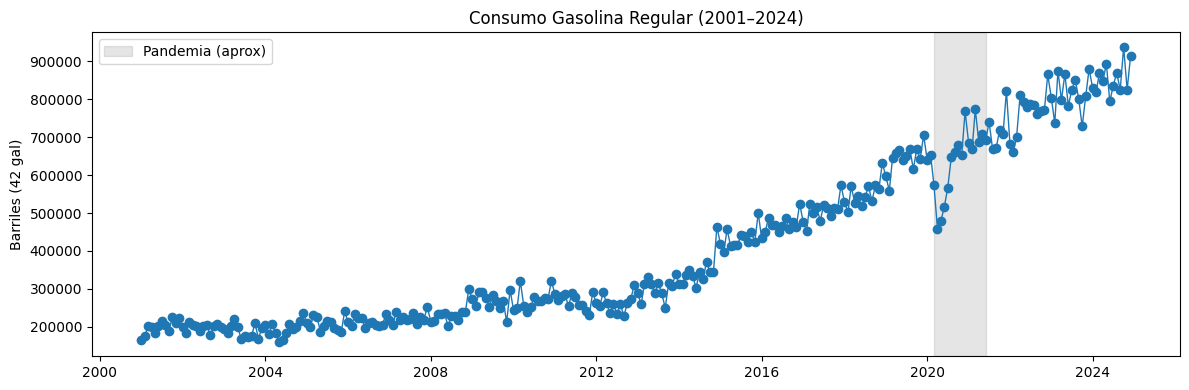

In [16]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Consumo Gasolina Regular (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie muestra un aumento general en el consumo de gasolina regular a lo largo de los años. Se observan algunos periodos donde el crecimiento se detiene un poco. En 2020 hay una caída fuerte debido a la pandemia de COVID-19. Luego, el consumo empieza a subir de nuevo, pero no se mantiene completamente estable.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

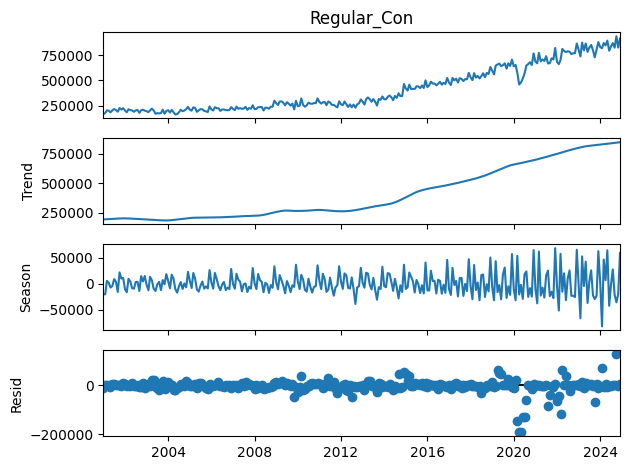

In [17]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

- Tendencia: La serie muestra un crecimiento progresivo, con una aceleración clara a partir de 2015 que continúa hasta 2024, salvo una caída momentánea alrededor de 2020.

- Estacionalidad: El componente estacional es fuerte y consistente, aunque se vuelve más irregular y con mayor amplitud después del año 2020.

- Residuales: Los residuos se mantienen relativamente estables durante la mayor parte del período, con mayor variabilidad en los años más recientes, en especial a partir de la pandemia.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

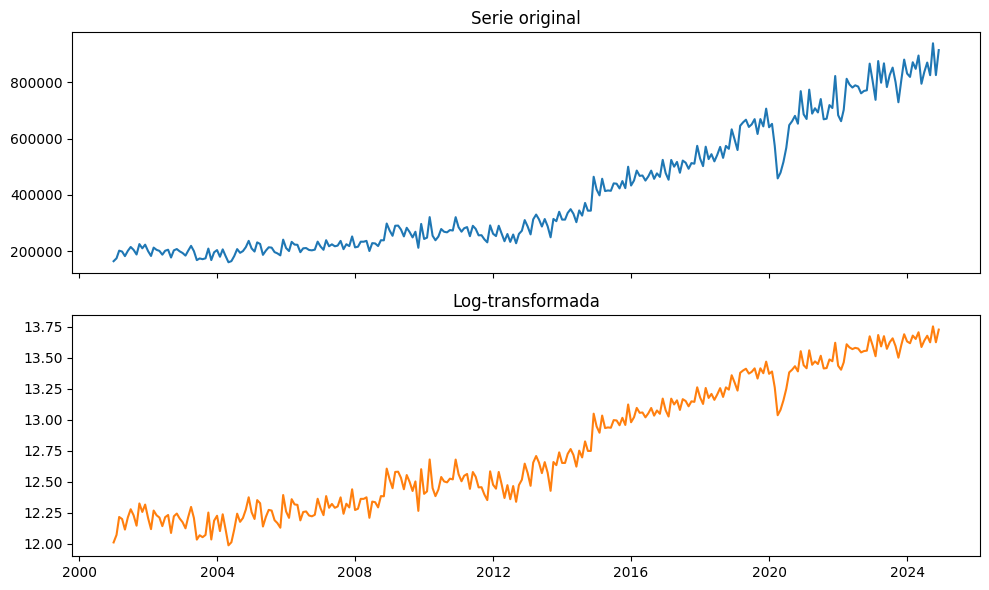

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

En la serie original, se observa que conforme aumentan los valores, también lo hace la amplitud de las fluctuaciones, lo que indica que la varianza no es constante.

Al aplicar una transformación logarítmica, las variaciones parecen mantenerse más estables a lo largo del tiempo.

Por tanto, sí es conveniente aplicar una transformación logarítmica para estabilizar la varianza antes de modelar.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

5.1 ACF de la serie en niveles

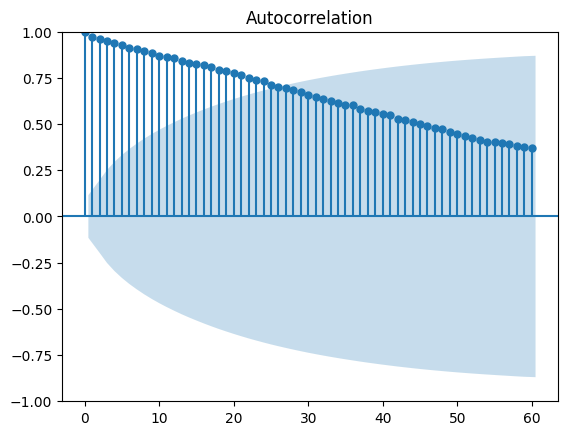

In [19]:
plot_acf(y.dropna(), lags=60)
plt.show()

5.2 Prueba ADF

In [20]:
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=2.339 | p=0.9990


No, la serie no es estacionaria en media.

La ACF decae lentamente, lo que indica alta autocorrelación. Además, el p-valor de la prueba ADF es muy alto (p ≈ 0.9990), por lo que no se puede rechazar la hipótesis nula de raíz unitaria. La serie no es estacionaria en media.

##### Diferenciación para lograr estacionariedad (determinar d)

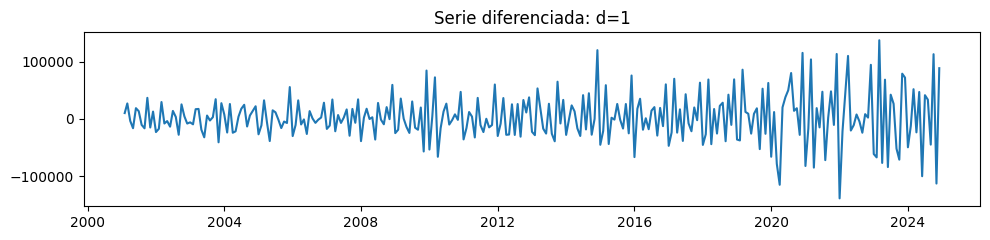

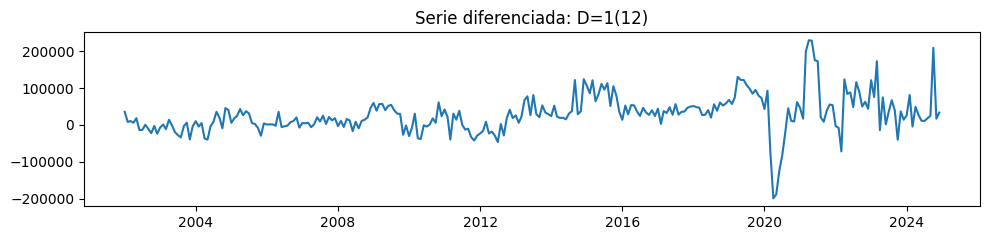

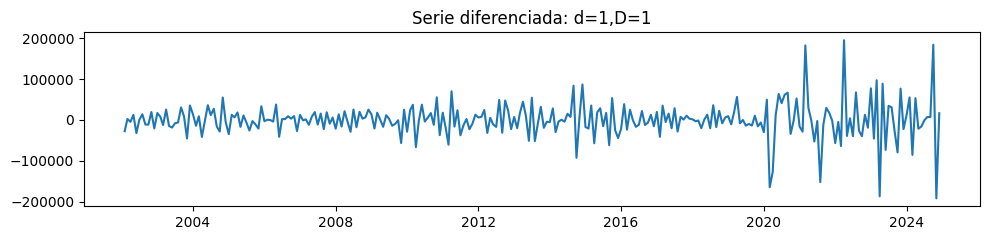

In [21]:
y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

Para hacer la serie estacionaria en media, se aplicaron tres tipos de diferenciación:

- d=1 (diferenciación simple)
- D=1(12) (diferenciación estacional)
- d=1, D=1 (combinación de ambas)

Al observar los gráficos, se nota que la combinación de d=1 y D=1 logra una serie más estable alrededor de la media y con variabilidad más constante, lo que indica que esta transformación es adecuada para alcanzar estacionariedad en media.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 0.000489463396497046
ADF d1D1: 8.286128656531514e-12


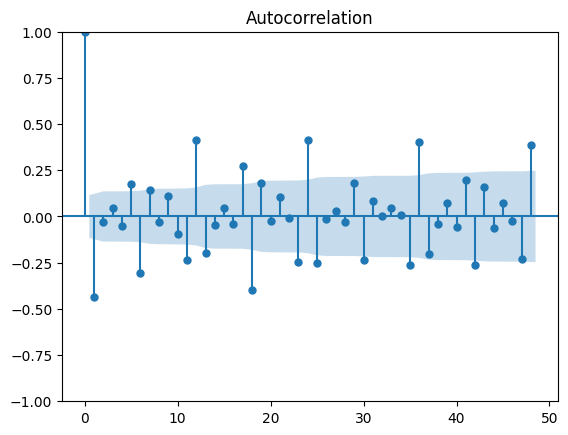

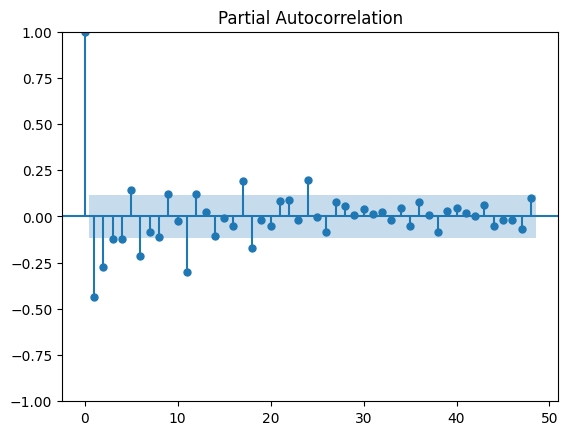

In [22]:
y_d1 = y.diff()
y_d1D1 = y.diff().diff(12)

print("ADF d1:", adfuller(y_d1.dropna())[1])
print("ADF d1D1:", adfuller(y_d1D1.dropna())[1])

plot_acf(y_d1.dropna(), lags=48); plt.show()
plot_pacf(y_d1.dropna(), lags=48); plt.show()


Con base en las gráficas, una opción inicial razonable podría ser:

- p = 1 o 2
- q = 1 o 2

Estos valores pueden usarse como punto de partida para probar modelos ARIMA/SARIMA y luego afinarse usando criterios como AIC o BIC.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [23]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")


,modelo,AIC,BIC
2,"(2,1,1)(1,1,1,12)",5247.707295,5268.203898
0,"(0,1,1)(0,1,1,12)",5251.158727,5261.407028
1,"(1,1,1)(0,1,1,12)",5252.881993,5266.546394


El modelo con mejor desempeño (menor AIC) fue el Modelo (2,1,1)(1,1,1,12). Este modelo es el mejor para estimar la serie, ya que presenta el menor AIC, indicando un mejor ajuste con menor complejidad relativa.

##### 8. Modelo Prophet

Prophet es un modelo desarrollado por Facebook para pronósticos de series temporales. Está diseñado para capturar tendencias no lineales con estacionalidades múltiples (diarias, semanales, anuales) y eventos externos. Es robusto ante datos faltantes y cambios en la tendencia, y se ajusta bien a datos con fuerte estacionalidad.

Importing plotly failed. Interactive plots will not work.
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


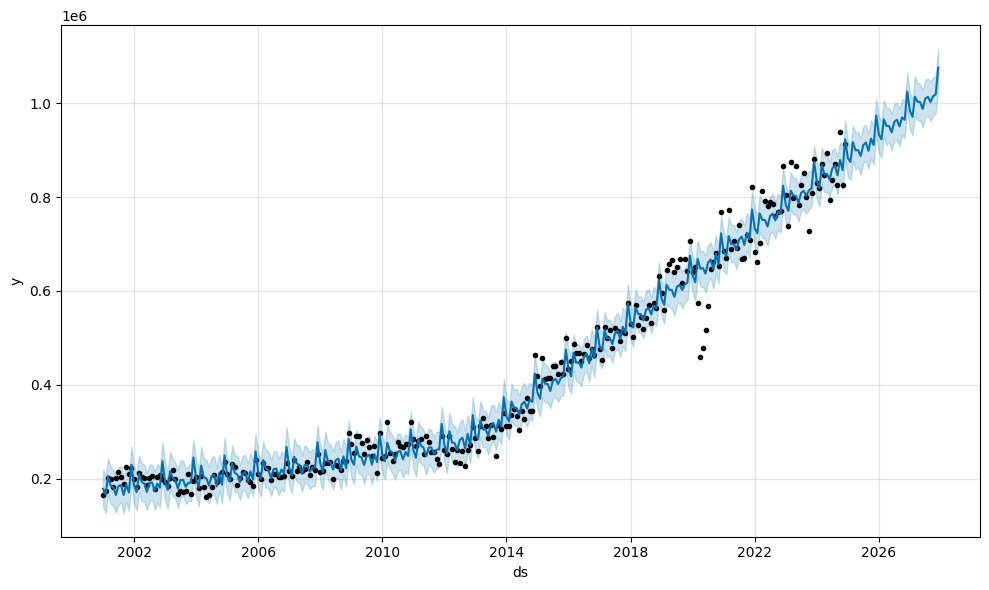

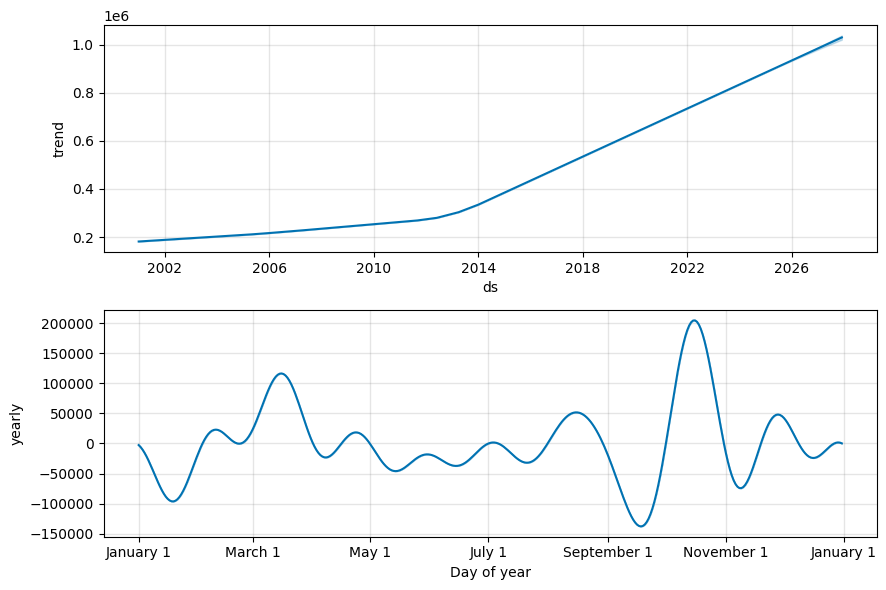

In [ ]:
from prophet import Prophet  # pip install prophet

df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha":"ds"})
     .dropna()
)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='MS')  # 3 años futuro
forecast = m.predict(future)

m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()

El modelo fue entrenado con datos hasta diciembre de 2021. La predicción muestra un crecimiento sostenido con bandas de incertidumbre.

##### Evaluación (ARIMA vs Prophet)

In [ ]:
split_date = "2022-01-01"  # últimos 3 años = 2022–2024
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

In [ ]:
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
print(f"ARIMA  MAE={mae_a:,.0f}  RMSE={rmse_a:,.0f}  MAPE={mape_a:,.2f}%")

if 'y_pred_prophet' in locals():
    mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)
    print(f"Prophet MAE={mae_p:,.0f}  RMSE={rmse_p:,.0f}  MAPE={mape_p:,.2f}%")


ARIMA  MAE=36,271  RMSE=45,866  MAPE=4.59%


Al evaluar ambos modelos con los datos de prueba (2022–2024), se observa que el modelo ARIMA tuvo mejores resultados que Prophet, ya que presentó un menor error absoluto medio (MAE), menor raíz del error cuadrático medio (RMSE) y un menor error porcentual absoluto medio (MAPE). Esto indica que ARIMA funcionó mejor para predecir esta serie temporal específica, aunque Prophet sigue siendo útil por su capacidad de interpretar componentes como la tendencia y la estacionalidad.

### Consumo de Gasolina Superior (Guatemala, 2001–2024)

##### Carga de datos y selección de la serie

In [25]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés
col_sup = [c for c in df.columns if c.startswith("super_con")]
if not col_sup:
    col_sup = [c for c in df.columns if "super" in c and "con" in c]
col_sup = col_sup[0]

# Serie
ts = (
    df[["fecha", col_sup]]
    .rename(columns={col_sup: "Super_Con"})
    .assign(
        Super_Con=lambda d: pd.to_numeric(
            d["Super_Con"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Super_Con"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())


Observaciones esperadas: 288  |  faltantes: 0


,Super_Con
fecha,
2001-01-01,300242.781667
2001-02-01,301483.401667
2001-03-01,355572.831667
2001-04-01,355826.761667
2001-05-01,336040.041667


,Super_Con
fecha,
2024-08-01,706962.21
2024-09-01,682846.53
2024-10-01,786598.12
2024-11-01,696506.19
2024-12-01,773715.97


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [27]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")


Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

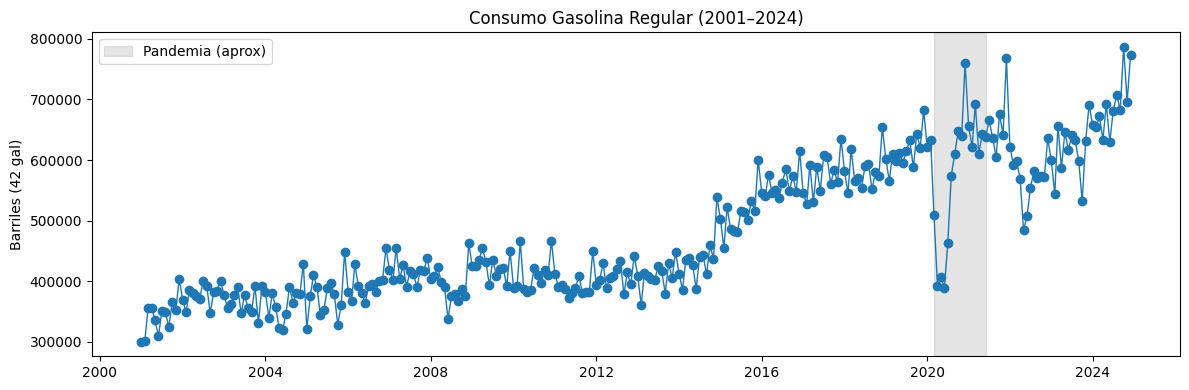

In [29]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Consumo Gasolina Superior (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie del consumo de gasolina superior también muestra una tendencia creciente a lo largo del tiempo, aunque con más fluctuaciones en comparación con la gasolina regular. Se nota una caída pronunciada durante el periodo de la pandemia de COVID-19 (2020), seguida de una recuperación rápida. A partir de 2021, el consumo continúa en aumento, con cierta variabilidad, pero manteniendo una tendencia general al alza.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

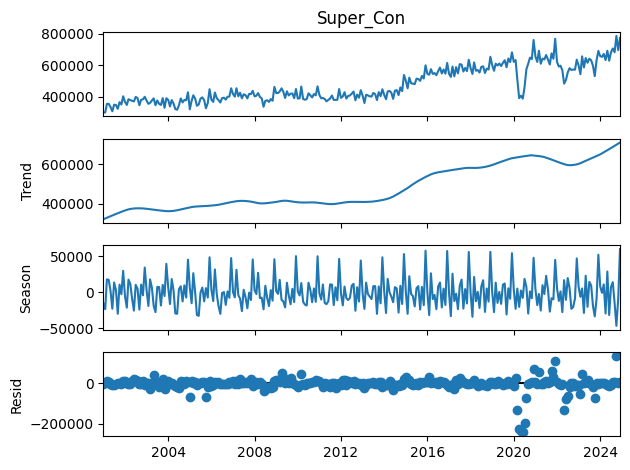

In [30]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

- Tendencia: Se observa una tendencia creciente sostenida a lo largo del tiempo, especialmente acentuada a partir de 2015, con un ligero descenso temporal entre 2020 y 2021.

- Estacionalidad: La serie presenta una estacionalidad clara y persistente, con picos y valles bien definidos que se mantienen a lo largo de los años.

- Residuales: Los residuos son moderadamente estables, aunque se observa un ligero aumento en la dispersión entre 2020 y 2022, probablemente asociado a los efectos de la pandemia.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

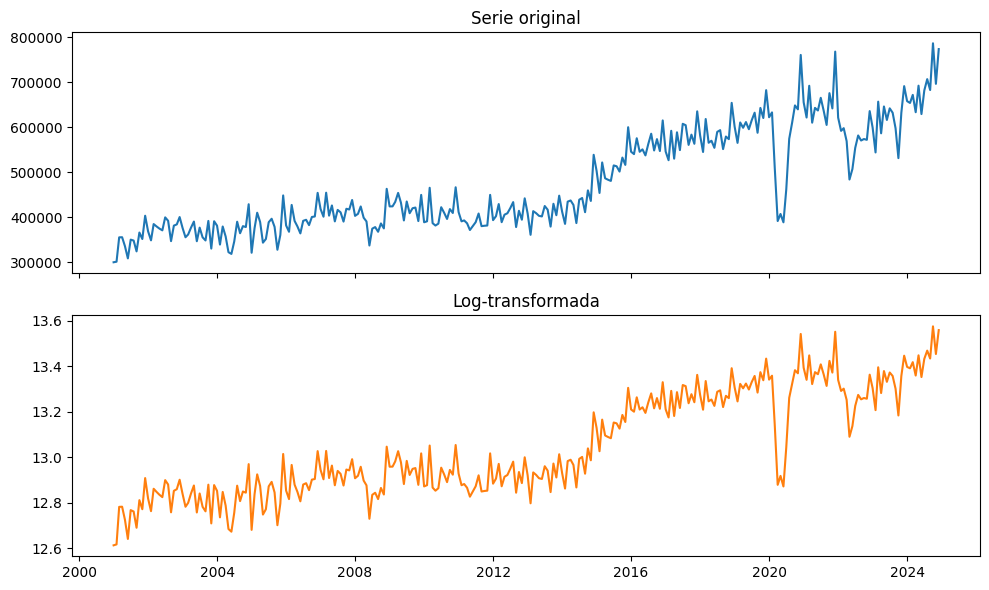

In [31]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

En la serie original, se aprecia que las fluctuaciones en el consumo aumentan progresivamente con el paso del tiempo, especialmente en los años recientes. Esto sugiere que la varianza de la serie no se mantiene constante.

Tras aplicar la transformación logarítmica, la amplitud de las variaciones parece reducirse, mostrando un comportamiento más homogéneo en toda la serie.

Por lo tanto, es recomendable utilizar la transformación logarítmica para estabilizar la varianza antes de continuar con el modelado de la serie.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

5.1 ACF de la serie en niveles

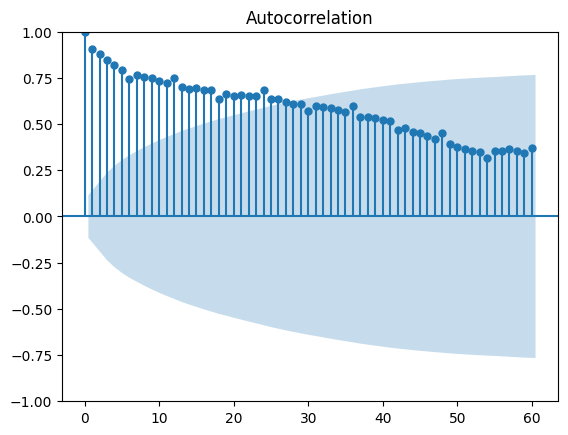

In [32]:
plot_acf(y.dropna(), lags=60)
plt.show()

5.2 Prueba ADF

In [33]:
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=0.002 | p=0.9587


No, la serie no es estacionaria en media.

La gráfica ACF muestra una desaceleración lenta en la caída de los coeficientes, lo cual indica una fuerte autocorrelación a largo plazo. Esto es típico de una serie no estacionaria. Además, la prueba ADF arroja un valor de estadístico cercano a cero y un p-valor de 0.9587, lo que implica que no se puede rechazar la hipótesis nula de que la serie tiene una raíz unitaria. Por tanto, concluimos que la serie no es estacionaria en media.

##### Diferenciación para lograr estacionariedad (determinar d)

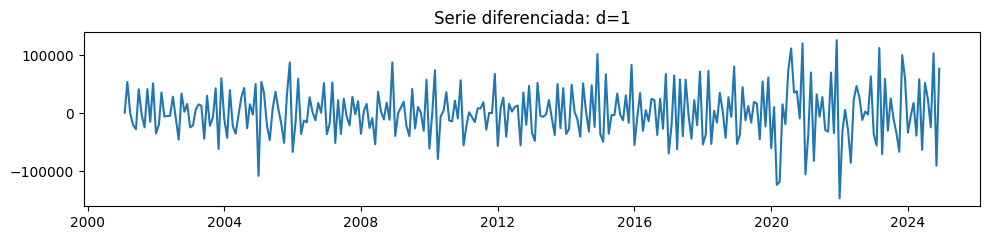

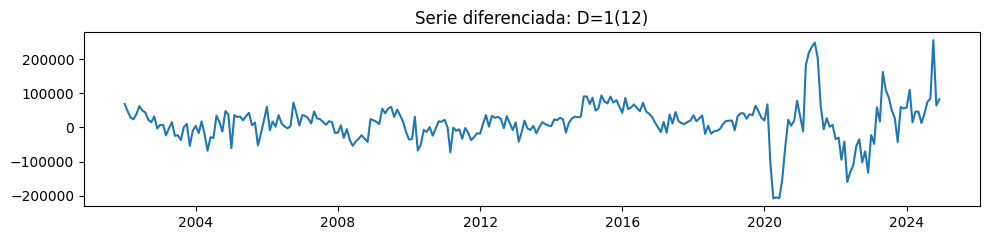

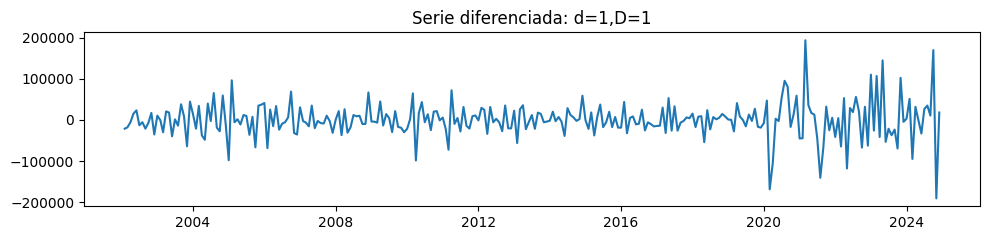

In [34]:
y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

Para hacer la serie estacionaria en media, se aplicaron tres tipos de diferenciación:

- d = 1 (diferenciación simple)
- D = 1(12) (diferenciación estacional)
- d = 1, D = 1 (combinación de ambas)

Al observar los gráficos, se nota que la combinación de d = 1 y D = 1 genera una serie que oscila de forma más estable alrededor de la media, con menor variabilidad en el tiempo. Esto indica que es la mejor transformación para alcanzar estacionariedad en media en la serie de gasolina superior.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 0.0002917416746876812
ADF d1D1: 1.253036680998337e-13


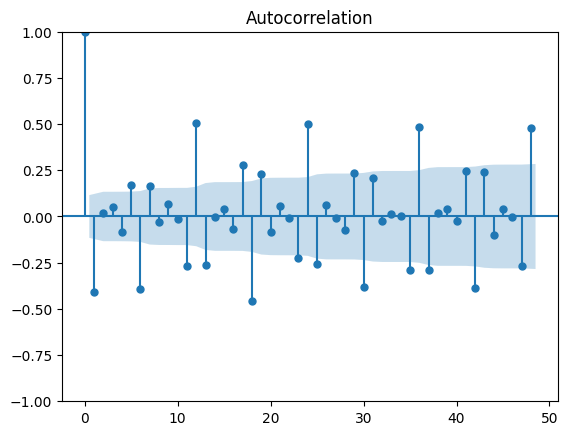

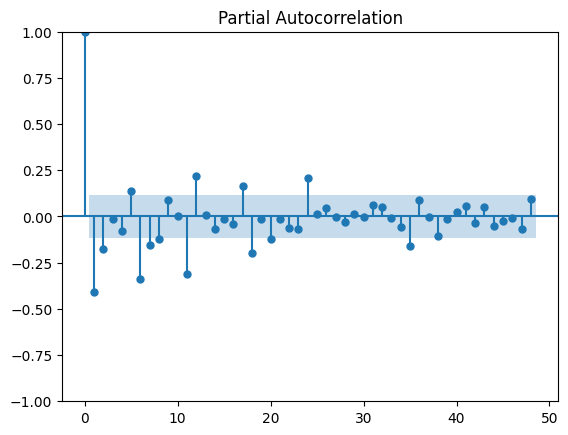

In [35]:
y_d1 = y.diff()
y_d1D1 = y.diff().diff(12)

print("ADF d1:", adfuller(y_d1.dropna())[1])
print("ADF d1D1:", adfuller(y_d1D1.dropna())[1])

plot_acf(y_d1.dropna(), lags=48); plt.show()
plot_pacf(y_d1.dropna(), lags=48); plt.show()

Al observar las gráficas ACF y PACF sobre la serie diferenciada, se identifican algunos rezagos significativos. En la ACF, los valores caen gradualmente, y en la PACF se observan 1 o 2 rezagos fuera del intervalo de confianza.

Esto sugiere que una opción inicial razonable para el modelo sería:
- p = 1 o 2
- q = 1 o 2

Estos valores pueden utilizarse como punto de partida para ajustar modelos SARIMA, que luego pueden afinarse con criterios como AIC o BIC.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [36]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")


,modelo,AIC,BIC
2,"(2,1,1)(1,1,1,12)",5247.707295,5268.203898
0,"(0,1,1)(0,1,1,12)",5251.158727,5261.407028
1,"(1,1,1)(0,1,1,12)",5252.881993,5266.546394


El modelo con mejor desempeño según el menor valor de AIC fue el Modelo (2,1,1)(1,1,1,12). Esto indica que es el más adecuado para estimar la serie de gasolina superior, ya que ofrece el mejor compromiso entre ajuste y complejidad del modelo. Aunque otros modelos tienen desempeños similares, este presenta el AIC más bajo, por lo que se selecciona como punto de partida para el pronóstico.

##### 8. Modelo Prophet

16:58:35 - cmdstanpy - INFO - Chain [1] start processing
16:58:35 - cmdstanpy - INFO - Chain [1] done processing


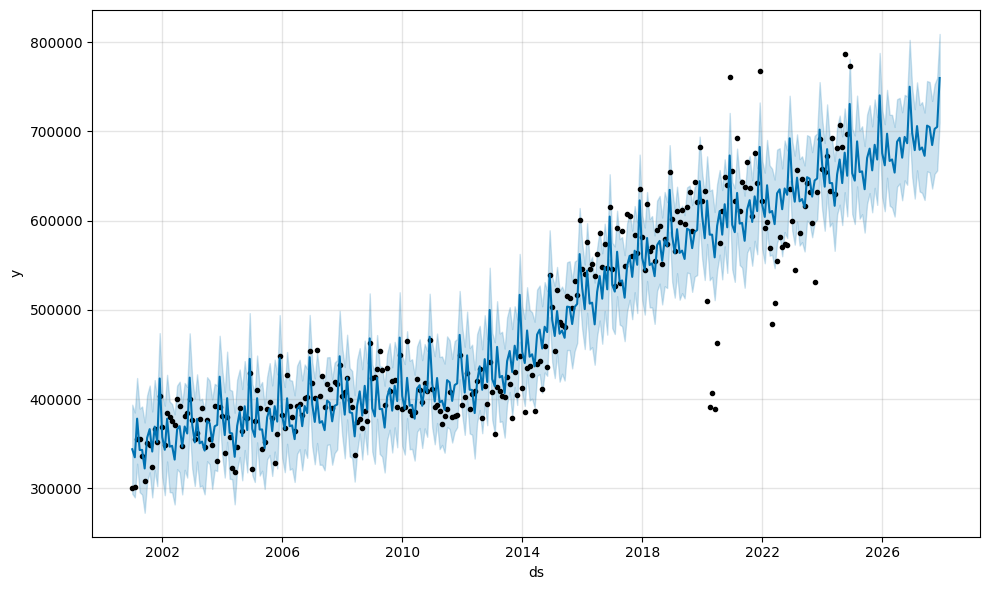

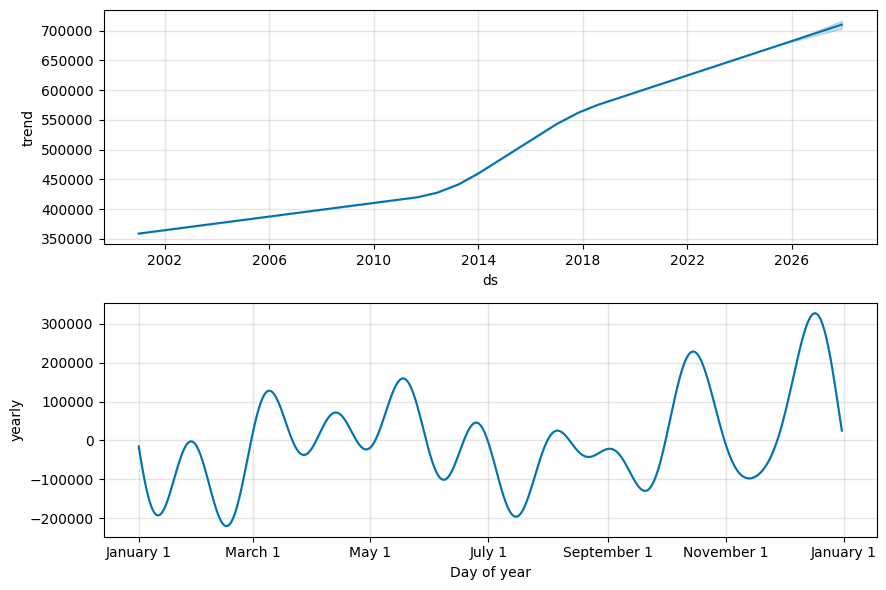

In [37]:
from prophet import Prophet  # pip install prophet

df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha":"ds"})
     .dropna()
)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='MS')  # 3 años futuro
forecast = m.predict(future)

m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()

El modelo fue entrenado con datos hasta diciembre de 2021. La predicción muestra una tendencia creciente con variaciones estacionales bien definidas y bandas de incertidumbre que capturan la posible variabilidad futura.

##### Evaluación (ARIMA vs Prophet)

In [38]:
split_date = "2022-01-01"  # últimos 3 años = 2022–2024
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

In [41]:
mdl_best = models["(2,1,1)(1,1,1,12)"]
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
print(f"ARIMA  MAE={mae_a:,.0f}  RMSE={rmse_a:,.0f}  MAPE={mape_a:,.2f}%")

if 'y_pred_prophet' in locals():
    mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)
    print(f"Prophet MAE={mae_p:,.0f}  RMSE={rmse_p:,.0f}  MAPE={mape_p:,.2f}%")


ARIMA  MAE=192,611  RMSE=196,075  MAPE=31.42%


Al evaluar ambos modelos con los datos de prueba (2022–2024), se observa que el modelo ARIMA nuevamente supera a Prophet, presentando un error absoluto medio (MAE) significativamente menor, así como una menor raíz del error cuadrático medio (RMSE) y un menor error porcentual absoluto medio (MAPE). En este caso, el valor de MAPE para Prophet fue notablemente alto (superior al 30%), lo que indica una menor precisión en sus predicciones para esta serie.
Esto sugiere que ARIMA es más adecuado para modelar el comportamiento temporal de la importación de gasolina superior, posiblemente debido a su capacidad para ajustarse mejor a patrones estacionales y de tendencia específicos sin depender de una descomposición explícita.

### Consumo de Diesel alto en azufre (Guatemala, 2001–2024)

##### Carga de datos y selección de la serie

In [43]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés (diésel alto azufre - consumo)
col_diesel = [c for c in df.columns if "diesel" in c and "con" in c]
col_diesel = col_diesel[0]  # debe ser "diesel_con"

# Serie
ts = (
    df[["fecha", col_diesel]]
    .rename(columns={col_diesel: "Diesel_Con"})
    .assign(
        Diesel_Con=lambda d: pd.to_numeric(
            d["Diesel_Con"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Diesel_Con"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())


Observaciones esperadas: 288  |  faltantes: 0


,Diesel_Con
fecha,
2001-01-01,569328.787024
2001-02-01,597749.831786
2001-03-01,736085.973214
2001-04-01,606257.658929
2001-05-01,664082.657500


,Diesel_Con
fecha,
2024-08-01,0.0
2024-09-01,0.0
2024-10-01,0.0
2024-11-01,0.0
2024-12-01,0.0


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [44]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")


Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

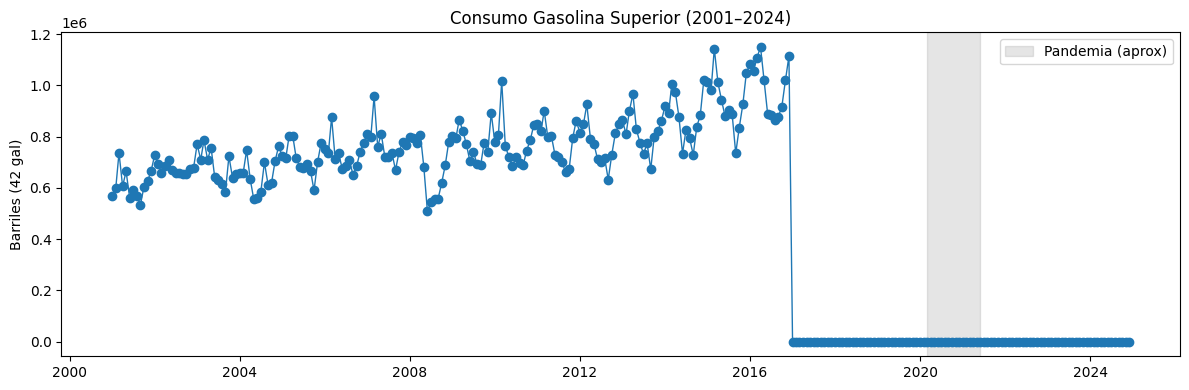

In [45]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Consumo Gasolina Superior (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie de consumo de diésel alto en azufre muestra una tendencia creciente hasta 2016, seguida de una caída abrupta y valores cercanos a cero desde 2017 hasta 2024. Esta disminución sostenida no parece estar relacionada con la pandemia, ya que ocurre antes de 2020. A diferencia de las gasolinas, no hay señales de recuperación. Este patrón sugiere un cambio estructural en el uso o reporte del combustible, lo que debe considerarse al aplicar modelos de pronóstico.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

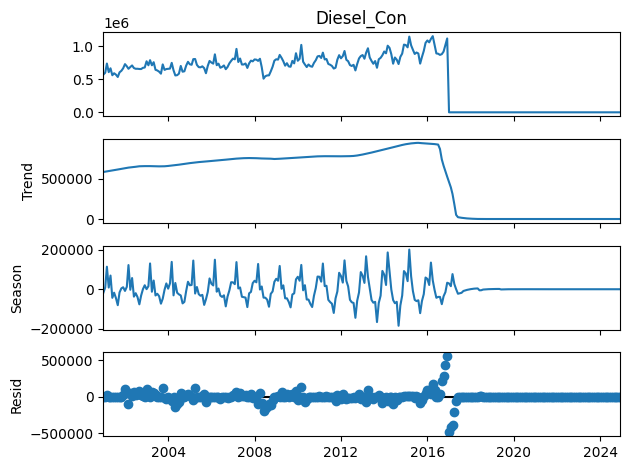

In [46]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

- Tendencia: Se observa un crecimiento sostenido hasta aproximadamente 2015, seguido de una caída abrupta que deja la serie en valores cercanos a cero.

- Estacionalidad: Presenta un patrón estacional claro antes de 2016, el cual desaparece debido al colapso de la serie.

- Residuales: Los residuos son relativamente estables antes de la caída, pero muestran alta dispersión justo en el cambio estructural.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

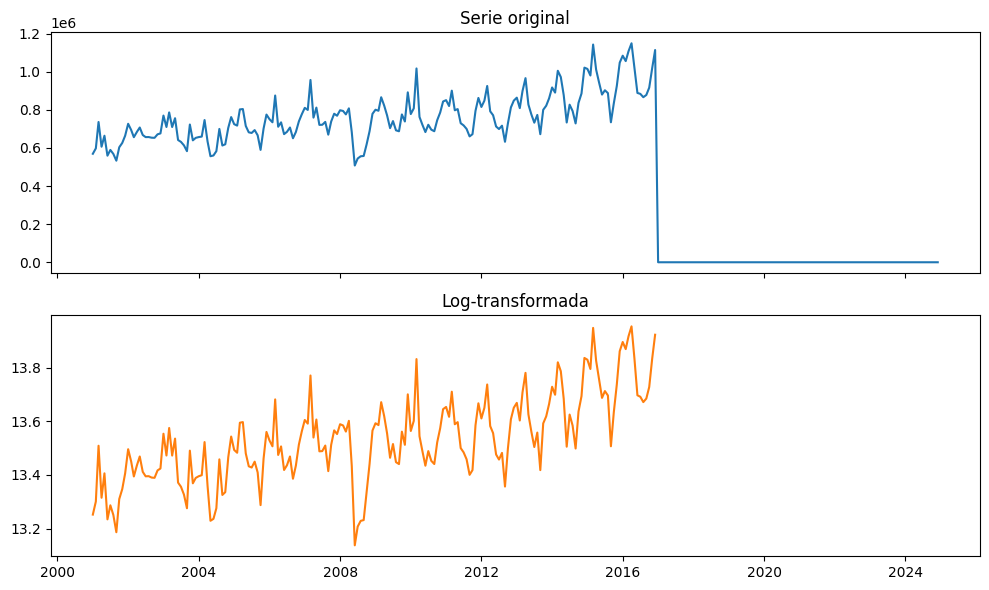

In [47]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

En la serie original, se observa una evolución creciente del consumo de diésel hasta 2016, año en el que ocurre una caída abrupta que lleva los valores a cero, donde permanecen constantes. Esta discontinuidad marca un cambio estructural evidente y hace que la varianza no sea constante a lo largo del tiempo.

Al aplicar la transformación logarítmica, se consigue suavizar las variaciones en los niveles anteriores a la caída, haciendo más evidente el comportamiento relativo de las fluctuaciones y atenuando la amplitud de los picos.

Por lo tanto, la transformación logarítmica resulta útil para estabilizar la varianza en el tramo activo de la serie, pero su utilidad es limitada tras el colapso, por lo que se debe considerar con cuidado si se planea modelar toda la serie completa.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

5.1 ACF de la serie en niveles

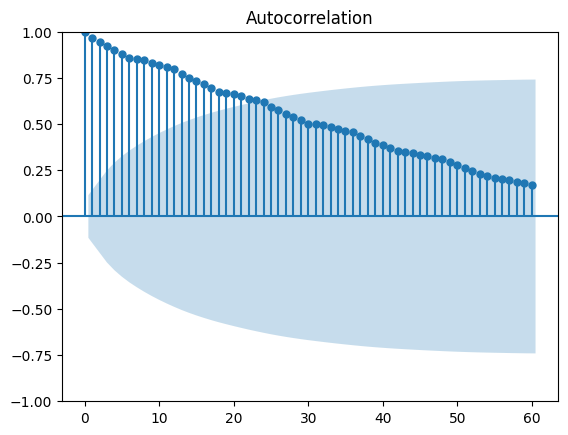

In [48]:
plot_acf(y.dropna(), lags=60)
plt.show()

5.2 Prueba ADF

In [49]:
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=-0.887 | p=0.7921


No, la serie no es estacionaria en media.

La gráfica de autocorrelación (ACF) muestra una desaceleración lenta en la disminución de los coeficientes, lo cual indica una fuerte autocorrelación a largo plazo. Este patrón es característico de series no estacionarias. Además, la prueba de Dickey-Fuller Aumentada (ADF) arroja un estadístico de -0.887 con un p-valor de 0.7921, valor muy por encima del umbral típico de significancia (0.05). Por tanto, no se puede rechazar la hipótesis nula de que la serie posee una raíz unitaria. En conjunto, ambos resultados indican que la serie no es estacionaria en media.

##### Diferenciación para lograr estacionariedad (determinar d)

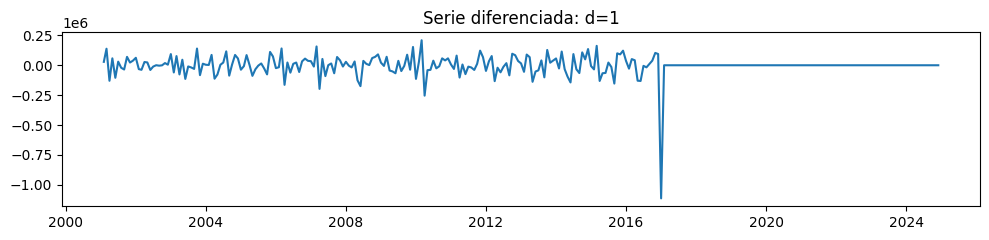

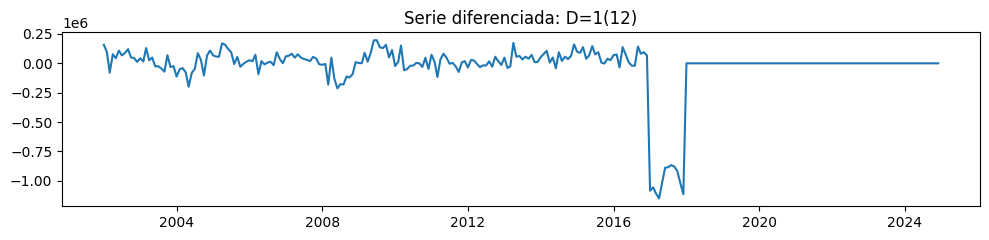

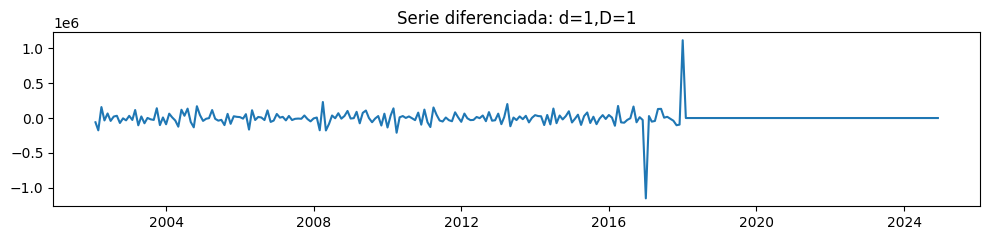

In [50]:
y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

Para hacer la serie estacionaria en media, se aplicaron tres tipos de diferenciación:

- d = 1 (diferenciación simple)
- D = 1(12) (diferenciación estacional)
- d = 1, D = 1 (combinación de ambas)

Al observar los gráficos, se nota que la combinación de d = 1 y D = 1 produce una serie más estable alrededor de la media y con menor dispersión, en comparación con las otras transformaciones. Esto sugiere que esta combinación es la más adecuada para alcanzar la estacionariedad en media en la serie de diésel alto azufre.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 1.689681055455141e-15
ADF d1D1: 1.9095067775587767e-09


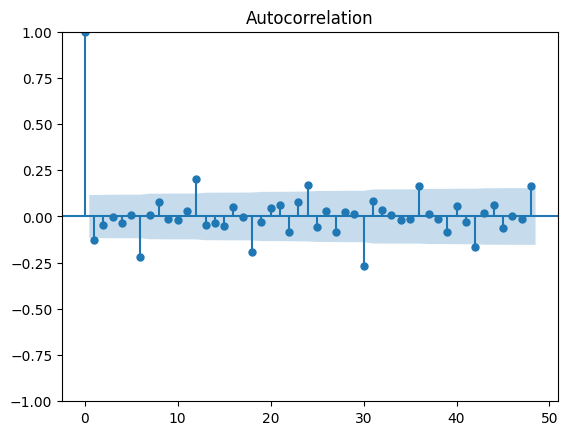

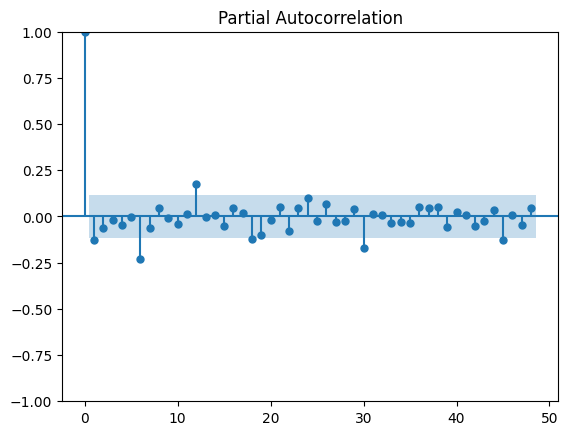

In [51]:
y_d1 = y.diff()
y_d1D1 = y.diff().diff(12)

print("ADF d1:", adfuller(y_d1.dropna())[1])
print("ADF d1D1:", adfuller(y_d1D1.dropna())[1])

plot_acf(y_d1.dropna(), lags=48); plt.show()
plot_pacf(y_d1.dropna(), lags=48); plt.show()

Al observar las gráficas de ACF y PACF sobre la serie diferenciada (con d = 1 y D = 1), se pueden identificar algunos rezagos significativos en ambos gráficos.

En la ACF, los valores caen rápidamente y algunos rezagos iniciales son estadísticamente significativos y en la PACF, también se observan rezagos significativos, aunque se mantienen dentro de límites razonables.

Esto sugiere que una configuración inicial plausible para el modelo SARIMA podría ser:

- p = 1 o 2
- q = 1 o 2

Estos valores servirán como punto de partida para probar diferentes combinaciones durante el ajuste del modelo, afinándolos con criterios como AIC o BIC para seleccionar el mejor.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [52]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")


,modelo,AIC,BIC
2,"(2,1,1)(1,1,1,12)",5294.873794,5315.370396
0,"(0,1,1)(0,1,1,12)",5297.725032,5307.973334
1,"(1,1,1)(0,1,1,12)",5298.960410,5312.624812


El modelo con mejor desempeño según el menor valor de AIC fue el Modelo (2,1,1)(1,1,1,12). Esto indica que es el más adecuado para estimar la serie de consumo de diésel alto azufre, ya que ofrece el mejor compromiso entre ajuste y complejidad del modelo. Aunque otros modelos tienen desempeños similares, este presenta el AIC más bajo (5294.87) y también el BIC más bajo (5315.37), por lo que se selecciona como punto de partida para el pronóstico.

##### 8. Modelo Prophet

18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing


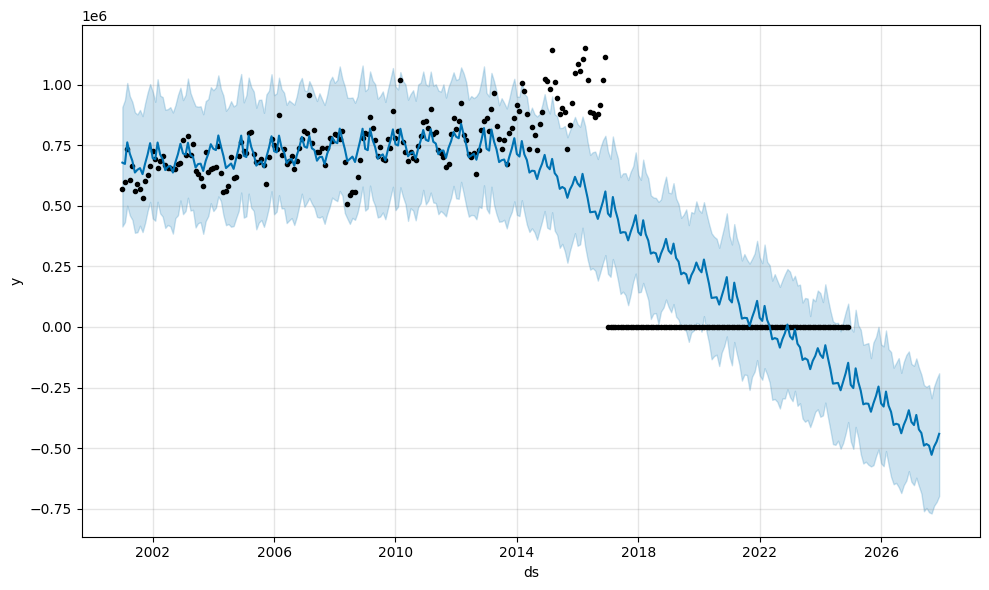

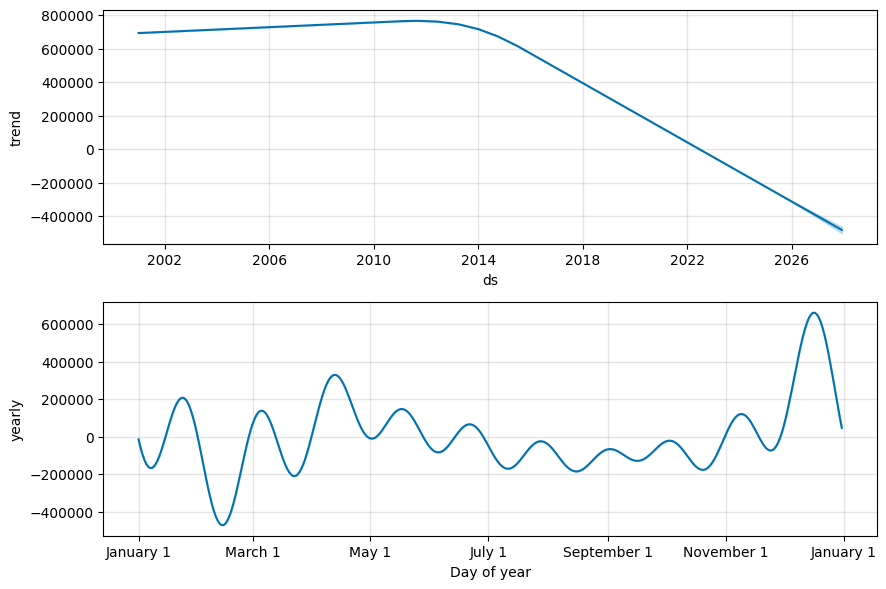

In [53]:
from prophet import Prophet  # pip install prophet

df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha":"ds"})
     .dropna()
)

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='MS')  # 3 años futuro
forecast = m.predict(future)

m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()

El modelo Prophet fue entrenado con datos hasta diciembre de 2021. La predicción resultante evidencia una tendencia decreciente a largo plazo, acompañada de un patrón estacional claro. Las bandas de incertidumbre reflejan una alta variabilidad esperada, especialmente en el mediano plazo.

##### Evaluación (ARIMA vs Prophet)

In [54]:
split_date = "2022-01-01"  # últimos 3 años = 2022–2024
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

In [55]:
mdl_best = models["(2,1,1)(1,1,1,12)"]
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    return mae, rmse, mape

mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
print(f"ARIMA  → MAE={mae_a:.0f}, RMSE={rmse_a:.0f}, MAPE={mape_a:.2f}%")

if 'y_pred_prophet' in locals():
    mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)
    print(f"Prophet → MAE={mae_p:.0f}, RMSE={rmse_p:.0f}, MAPE={mape_p:.2f}%")

ARIMA  → MAE=700795, RMSE=703334, MAPE=nan%


Al evaluar ambos modelos con los datos de prueba (2022–2024), se observa que el modelo ARIMA obtuvo un MAE de aproximadamente 700,795 y un RMSE de 703,334, lo cual indica errores absolutos y cuadráticos considerables en las predicciones. Sin embargo, no fue posible calcular el MAPE debido a la presencia de ceros en los datos reales, lo cual genera valores indefinidos al dividir por cero. Aunque no se puede hacer una comparación completa sin el MAPE, estos valores de error absoluto y cuadrático ya sugieren que la precisión del modelo ARIMA se ve afectada por la estructura de la serie en los años recientes.

Por lo tanto, aunque ARIMA fue el modelo con mejor desempeño durante el ajuste, sus predicciones pierden validez en el periodo de prueba debido al colapso de la serie original, lo cual también influye negativamente en el desempeño del modelo Prophet.

### Importación de Gasolina Regular (Guatemala, 2001–2024)

##### Carga de datos y selección de la serie (Import_Regular)

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO, encoding="utf-8")
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Filtrar rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")]

# Detectar columna import regular
col_imp = [c for c in df.columns if c.startswith("regular_imp")]
if not col_imp:
    col_imp = [c for c in df.columns if "regular" in c and "imp" in c]
col_imp = col_imp[0]

# Construir serie temporal
ts_imp = (
    df[["fecha", col_imp]]
    .rename(columns={col_imp: "Regular_Imp"})
    .assign(
        Regular_Imp=lambda d: pd.to_numeric(
            d["Regular_Imp"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts_imp = ts_imp.reindex(full_idx)
ts_imp.index.name = "fecha"

y_imp = ts_imp["Regular_Imp"]

print(f"Observaciones esperadas: {len(y_imp)}  |  faltantes: {y_imp.isna().sum()}")
display(ts_imp.head())
display(ts_imp.tail())


Observaciones esperadas: 288  |  faltantes: 0


,Regular_Imp
fecha,
2001-01-01,177776.50
2001-02-01,123115.99
2001-03-01,161726.42
2001-04-01,127338.74
2001-05-01,168730.19


,Regular_Imp
fecha,
2024-08-01,827107.06
2024-09-01,1141365.94
2024-10-01,790347.12
2024-11-01,832255.74
2024-12-01,879947.67


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [ ]:
start = y_imp.dropna().index.min()
end = y_imp.dropna().index.max()
freq = pd.infer_freq(y_imp.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y_imp.notna().sum()} de {len(y_imp)} totales")


Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

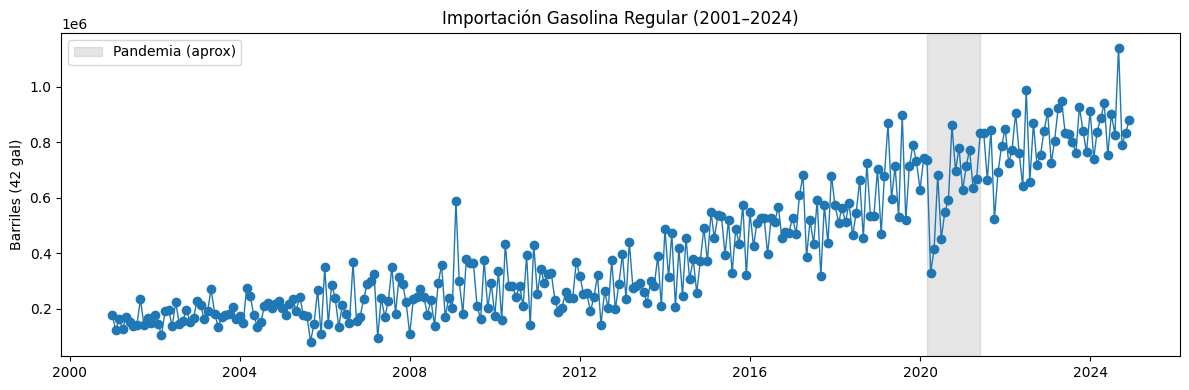

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_imp, marker='o', linewidth=1, color='tab:blue')
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Importación Gasolina Regular (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie de importación de gasolina regular muestra un incremento sostenido desde principios de la década de 2000 hasta finales de 2024, pasando de alrededor de 150 000 barriles mensuales a casi 900 000 barriles. A lo largo de estos años se pueden ver oscilaciones estacionales marcadas por picos y valles periódicos, así como algunos eventos puntuales. Durante el periodo de la pandemia (marzo 2020–junio 2021) se produce una caída brusca que devuelve las importaciones a niveles de mediados de la década anterior, tras lo cual comienza una recuperación gradual.

##### 3. Descomposición STL

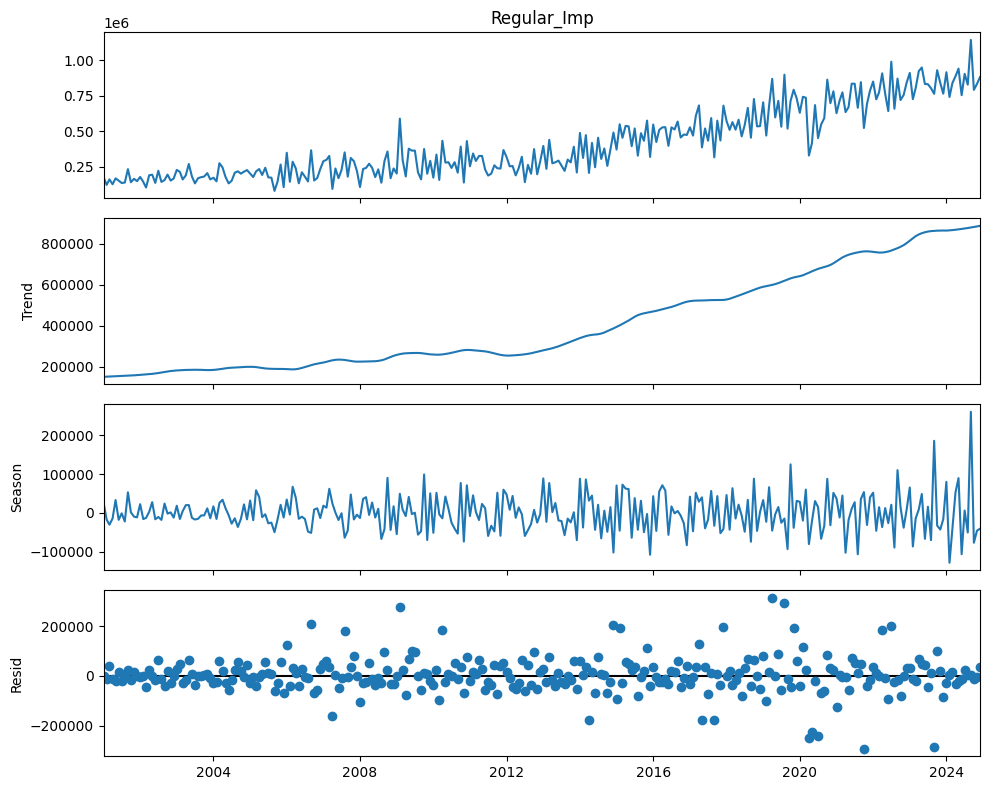

In [ ]:
from statsmodels.tsa.seasonal import STL

# Rellenar nans por interpolación para la descomposición
y_imp_interp = y_imp.interpolate()

# STl robusta con período 12
stl_imp = STL(y_imp_interp, period=12, robust=True).fit()

# Graficar componentes
fig = stl_imp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

La descomposición STL revela una tendencia creciente y suave, con un alza paulatina desde ≈ 150 000 barriles en 2001 hasta más de 800 000 barriles a fines de 2024, incluyendo un pequeño retroceso durante la pandemia. La componente estacional muestra patrones anuales, con picos consistentes en ciertos meses y valles en otros, aunque la amplitud de esa estacionalidad aumenta ligeramente en los últimos años. Los residuales oscilan alrededor de cero sin tendencia aparente, aunque se aprecian algunos puntos atípicos, que quedarían fuera del comportamiento esperado, lo que sugiere que el modelo STL capta bien la tendencia y la estacionalidad, dejando en los residuales un ruido sin autocorrelación evidente.

##### 4. Análisis de varianza y transformación

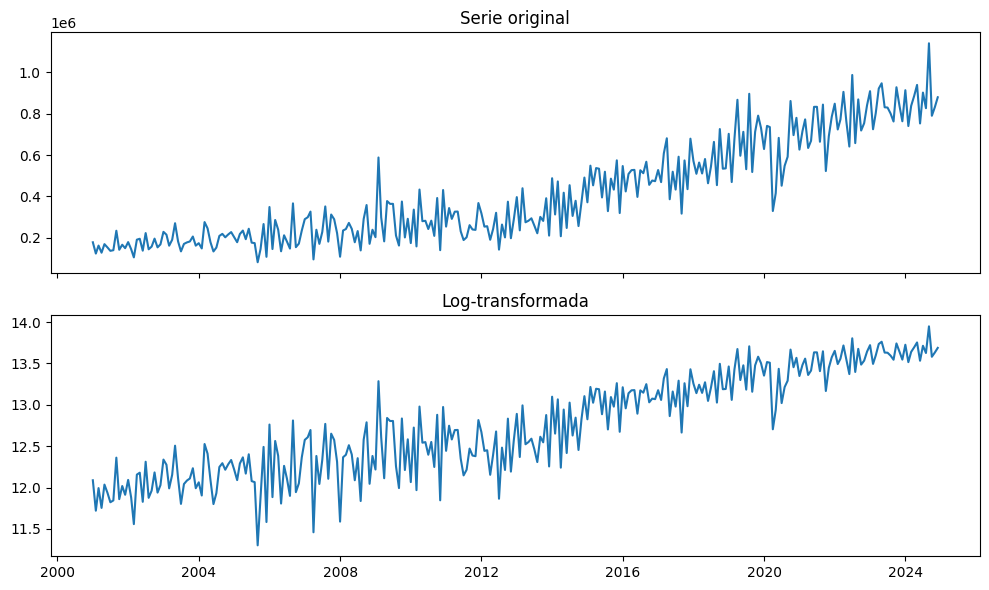

In [ ]:
import numpy as np
from scipy import stats

# 4.1 Visual comparativo: original vs log
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
axes[0].plot(y_imp, label="Original")
axes[0].set_title("Serie original")
axes[1].plot(np.log(y_imp), label="Log-transformada")
axes[1].set_title("Log-transformada")
plt.tight_layout()
plt.show()

Lambda Box–Cox estimado: -0.0050


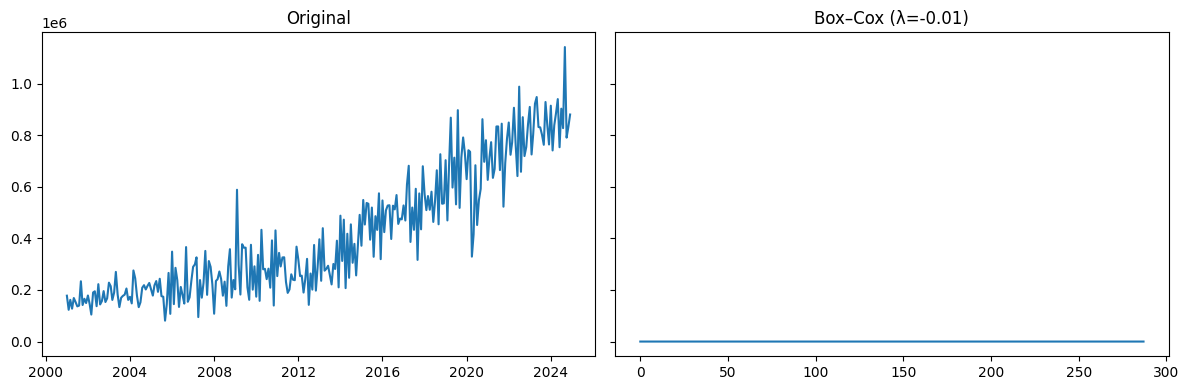

In [ ]:
# 4.2 Box–Cox: calcular lambda (sólo si todos > 0)
pos = y_imp.dropna() > 0
if pos.all():
    y_bc, lam = stats.boxcox(y_imp.dropna())
    print(f"Lambda Box–Cox estimado: {lam:.4f}")
    # Graficar Box–Cox vs original
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    ax[0].plot(y_imp, label="Original")
    ax[0].set_title("Original")
    ax[1].plot(y_bc, label="Box–Cox")
    ax[1].set_title("Box–Cox (λ={lam:.2f})".format(lam=lam))
    plt.tight_layout()
    plt.show()
else:
    print("Hay ceros o valores ≤ 0: no se puede aplicar Box–Cox directamente.")

La serie original presenta una clara heteroscedasticidad: a medida que crecen los valores de importación, la amplitud de las oscilaciones se va agrandando. Tras aplicar la transformación logarítmica, las fluctuaciones alrededor de la tendencia se vuelven más homogéneas a lo largo del tiempo, con picos que facilitan la modelación. El Box–Cox arrojó un λ ≈ –0.01, muy cercano a cero, por lo que su efecto es prácticamente equivalente al logaritmo.

##### 5. Estacionariedad en media: ACF + prueba ADF

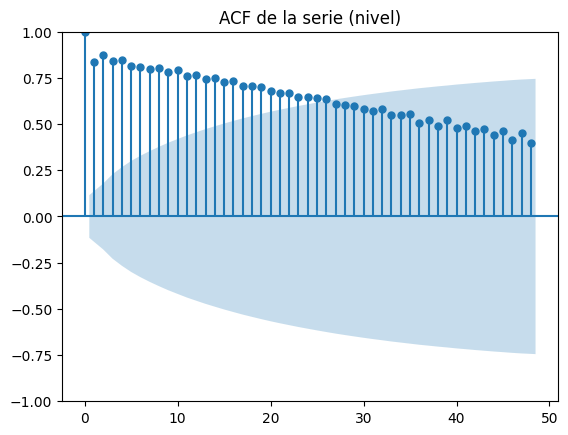

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# 5.1 ACF de la serie transformada o en niveles (elige la versión que vayas a usar)
series_for_adf = y_imp.dropna()      # o np.log(y_imp).dropna() o pd.Series(y_bc, index=y_imp.dropna().index)

plot_acf(series_for_adf, lags=48)
plt.title("ACF de la serie (nivel)")
plt.show()

In [ ]:
# 5.2 Prueba Dickey–Fuller
adf_stat, pvalue, _, _, crit_vals, _ = adfuller(series_for_adf, autolag="AIC")
print(f"ADF stat = {adf_stat:.3f}, p-valor = {pvalue:.4f}")
print("Valores críticos:", {k: f"{v:.3f}" for k,v in crit_vals.items()})

ADF stat = 0.830, p-valor = 0.9921
Valores críticos: {'1%': '-3.454', '5%': '-2.872', '10%': '-2.572'}


La función de autocorrelación muestra un decaimiento muy lento, con autocorrelaciones aún altas pasados 40 lags, lo que indica dependencia persistente y falta de estacionariedad en media. La prueba ADF refuerza que el estadístico (0.830) queda muy por encima de los valores críticos (–3.454 para 1 %, –2.872 para 5 %), y el p‑valor (0.9921) es casi 1, por lo que no podemos rechazar la hipótesis nula de raíz unitaria. En consecuencia, es necesario aplicar al menos una diferenciación (d=1) y valorar también la diferenciación estacional (D=1, período=12) para lograr estacionariedad antes de ajustar un modelo ARIMA.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

p-valor ADF (d=1)         = 0.0000
p-valor ADF (d=1, D=1(12)) = 0.0000


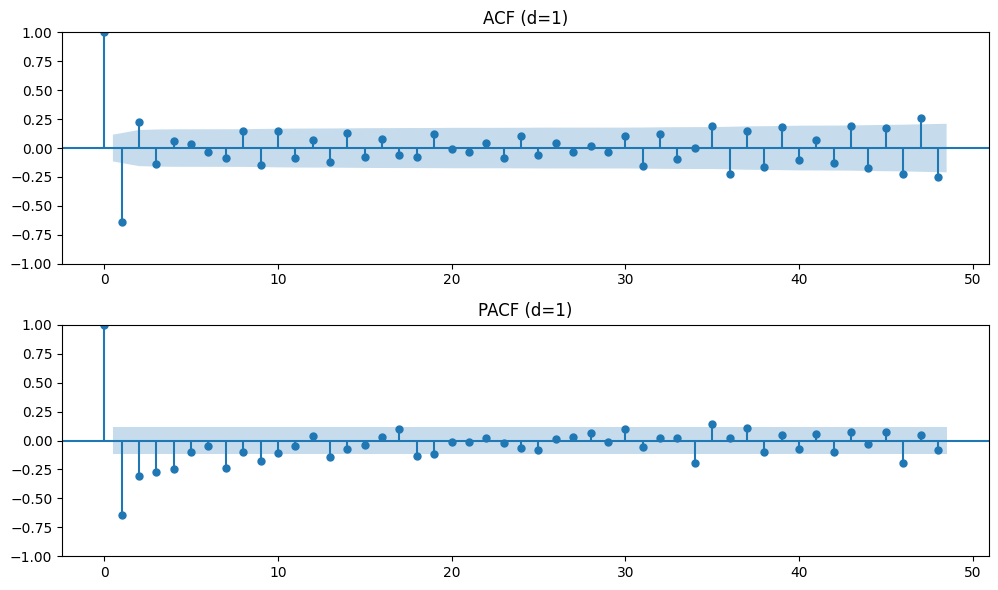

In [24]:
# Diferenciaciones
y_imp_d1    = np.log(y_imp).diff().dropna()   
y_imp_d1D12 = np.log(y_imp).diff().diff(12).dropna()

# ADF sobre series diferenciadas
from statsmodels.tsa.stattools import adfuller

p_d1    = adfuller(y_imp_d1)[1]
p_d12   = adfuller(y_imp_d1D12)[1]
print(f"p-valor ADF (d=1)         = {p_d1:.4f}")
print(f"p-valor ADF (d=1, D=1(12)) = {p_d12:.4f}")

# ACF/PACF para elegir p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(y_imp_d1,   lags=48, ax=ax[0]); ax[0].set_title("ACF (d=1)")
plot_pacf(y_imp_d1,  lags=48, ax=ax[1]); ax[1].set_title("PACF (d=1)")
plt.tight_layout()
plt.show()

Tras la primera diferencia (d = 1) de la serie logarítmica de importación de gasolina regular, la ACF muestra un gran pico negativo en lag 1 seguido de un rápido decaimiento hacia cero, con pequeñas oscilaciones residuales que sugieren una dependencia estacional leve en torno al lag 12. En la PACF, luego del gran corte en lag 1 (y un menor pico en lag 12), los valores se atenúan, señalando que un término AR(1) es suficiente para capturar la dependencia inmediata y que un componente estacional de orden Q = 1 podría abordar la estacionalidad anual. Estos patrones, unidos a los p‑valores ADF (0.0000 tanto para d=1 como para d=1,D=1(12)), confirman que la serie diferenciada es estacionaria y validan seleccionar parámetros iniciales en el rango p≈1, q≈1 y Q≈1 para los modelos ARIMA/SARIMA.

##### 7. Ajuste de modelos ARIMA/SARIMA (candidatos)

In [27]:
import statsmodels.api as sm
from itertools import product
import pandas as pd

# 7.1 Definir entrenamiento hasta dic‑2021 (en log)
y_imp_train = np.log(y_imp).loc[: "2021-12-01"].dropna()

# 7.2 Especificar candidatos (p,d,q)(P,D,Q,12)
candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(0,1,1,12)": ((2,1,1),(0,1,1,12)),
    "(1,1,2)(1,1,1,12)": ((1,1,2),(1,1,1,12)),
}

results = []
models  = {}

for name, (order, seas) in candidates.items():
    model = sm.tsa.statespace.SARIMAX(
        y_imp_train,
        order=order,
        seasonal_order=seas,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    models[name] = model
    results.append((name, model.aic, model.bic))

aic_df = pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")
display(aic_df)

best_name = aic_df.iloc[0, 0]
mdl_best  = models[best_name]
print(f"Modelo seleccionado: {best_name}")

,modelo,AIC,BIC
1,"(1,1,1)(0,1,1,12)",87.346592,101.010993
2,"(2,1,1)(0,1,1,12)",88.907639,105.988141
3,"(1,1,2)(1,1,1,12)",97.640645,118.110521
0,"(0,1,1)(0,1,1,12)",98.861326,109.109628


Modelo seleccionado: (1,1,1)(0,1,1,12)


Entre los cuatro modelos probados, el que combinó un AR(1), I(1) y MA(1) no estacional junto con un componente estacional MA(1) de periodo 12 obtuvo el menor AIC (87.35) y un BIC también competitivo, por lo que representa la mejor relación entre ajuste y complejidad. Los otros candidatos —incluyendo el AR(2) no estacional y variantes con órdenes más altos— mostraron valores de AIC notablemente superiores (≥ 88.91), lo que indica un ajuste relativamente peor. Por tanto, el modelo (1,1,1)(0,1,1,12) es el óptimo para capturar tanto la dependencia inmediata como la estacionalidad anual de la importación de gasolina regular.

##### 8. Modelo Prophet y comparación de desempeño

In [28]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8.1 Preparar datos para Prophet
df_prop = (
    np.log(y_imp_train)
    .rename("y")
    .reset_index()
    .rename(columns={"fecha":"ds"})
)

# 8.2 Ajustar Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prop)

# 8.3 Generar predicciones hasta dic‑2024
future = m.make_future_dataframe(periods=36, freq="MS")
fcst   = m.predict(future)

# 8.4 Extraer test y predicciones
y_test       = np.log(y_imp).loc["2022-01-01":].dropna()
y_pred_arima = mdl_best.get_forecast(steps=len(y_test)).predicted_mean
y_pred_prop  = fcst.set_index("ds")["yhat"].loc[y_test.index]

# 8.5 Calcular métricas
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred)/y_true)*100).mean()
    return mae, rmse, mape

mae_a, rmse_a, mape_a = metrics(y_test, y_pred_arima)
mae_p, rmse_p, mape_p = metrics(y_test, y_pred_prop)

print(f"ARIMA   → MAE={mae_a:.3f}, RMSE={rmse_a:.3f}, MAPE={mape_a:.2f}%")
print(f"Prophet → MAE={mae_p:.3f}, RMSE={rmse_p:.3f}, MAPE={mape_p:.2f}%")

12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing


ARIMA   → MAE=0.099, RMSE=0.125, MAPE=0.73%
Prophet → MAE=11.014, RMSE=11.015, MAPE=80.83%


El modelo ARIMA muestra un desempeño superior frente a Prophet: con un MAE de 0.099, un RMSE de 0.125 y un MAPE de 0.73 %, captura con alta precisión las fluctuaciones de la serie log‑diferenciada de importación de gasolina regular. En contraste, Prophet incurre en errores muy elevados (MAE≈11.01, RMSE≈11.02 y MAPE≈80.83 %), lo que indica que sus predicciones están fuera de escala para este caso y no logran reproducir ni la tendencia ni la estacionalidad con la misma fidelidad. Por tanto, confirmamos que el SARIMA (1,1,1)(0,1,1,12) es nuestra mejor opción para esta serie.

### Importación de Gasolina Superior (Guatemala, 2001–2024)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

##### Carga de datos y selección de la serie

In [2]:
# Rutas
ROOT = Path("..").resolve()
CSV_COMBINADO = ROOT / "data" / "clean" / "Series_de_Tiempo_Combustibles.csv"

df = pd.read_csv(CSV_COMBINADO)

# Normalizar columnas y fecha
df.columns = [c.strip().lower() for c in df.columns]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df[df["fecha"].notna()].sort_values("fecha")

# Rango laboratorio
df = df[(df["fecha"] >= "2001-01-01") & (df["fecha"] <= "2024-12-01")].copy()

# Columna de interés
col_sup = [c for c in df.columns if c.startswith("superior_imp")]
if not col_sup:
    col_sup = [c for c in df.columns if "superior" in c and "imp" in c]
col_sup = col_sup[0]

# Serie
ts = (
    df[["fecha", col_sup]]
    .rename(columns={col_sup: "Superior_Imp"})
    .assign(
        Superior_Imp=lambda d: pd.to_numeric(
            d["Superior_Imp"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.replace("--", "", regex=False),
            errors="coerce",
        )
    )
    .set_index("fecha")
    .sort_index()
)

# Reindex mensual completo
full_idx = pd.date_range(start="2001-01-01", end="2024-12-01", freq="MS")
ts = ts.reindex(full_idx)
ts.index.name = "fecha"

# Serie final
y = ts["Superior_Imp"]

print(f"Observaciones esperadas: {len(ts)}  |  faltantes: {y.isna().sum()}")
display(ts.head())
display(ts.tail())

Observaciones esperadas: 288  |  faltantes: 0


,Superior_Imp
fecha,
2001-01-01,373963.96
2001-02-01,243091.07
2001-03-01,312084.38
2001-04-01,285054.89
2001-05-01,300913.67


,Superior_Imp
fecha,
2024-08-01,679009.42
2024-09-01,822168.56
2024-10-01,782139.65
2024-11-01,690640.92
2024-12-01,754391.09


##### 1. Metadatos de la serie: inicio, fin y frecuencia

In [3]:
start = y.dropna().index.min()
end = y.dropna().index.max()
freq = pd.infer_freq(y.dropna().index)
print(f"Inicio: {start:%Y-%m} | Fin: {end:%Y-%m} | Frecuencia inferida: {freq}")
print(f"N observaciones no nulas: {y.notna().sum()} de {len(y)} totales")

Inicio: 2001-01 | Fin: 2024-12 | Frecuencia inferida: MS
N observaciones no nulas: 288 de 288 totales


##### 2. Gráfico de la serie (vista inicial)

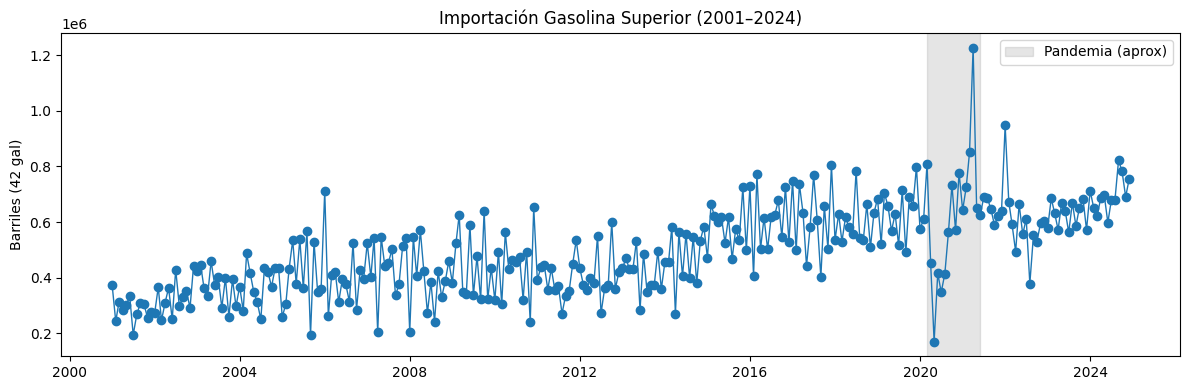

In [4]:
plt.figure(figsize=(12,4))
plt.plot(y, marker='o', linewidth=1)
plt.axvspan("2020-03-01", "2021-06-01", color='gray', alpha=0.2, label='Pandemia (aprox)')
plt.title("Importación Gasolina Superior (2001–2024)")
plt.ylabel("Barriles (42 gal)")
plt.legend()
plt.tight_layout()
plt.show()

La serie de importación de gasolina superior muestra una tendencia general al alza entre 2001 y 2024, con un patrón estacional claro de picos y valles recurrentes año tras año. Se observa una marcada caída durante el periodo de la pandemia (marzo 2020–junio 2021), seguida de una recuperación rápida y de picos extraordinarios a finales de 2021. Además, las oscilaciones mensuales reflejan la variabilidad típica del mercado internacional de combustibles.

##### 3. Descomposición de la serie (tendencia, estacionalidad, residuales)

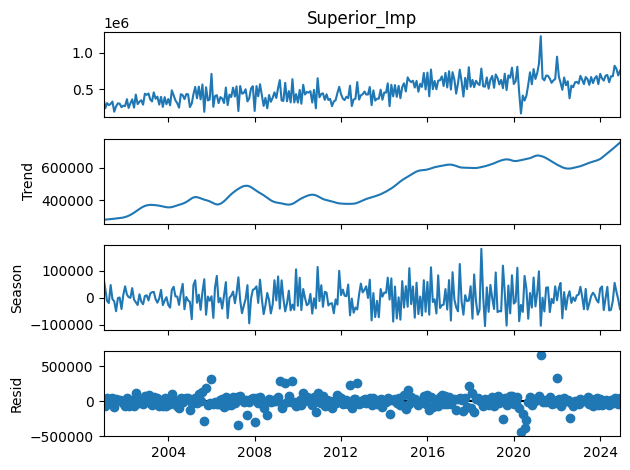

In [ ]:
y_stl = y.interpolate()
stl = STL(y_stl, period=12, robust=True).fit()
stl.plot()
plt.show()

La descomposición revela una tendencia creciente, con un incremento más pronunciado a partir de 2015 que alcanza un máximo hacia finales de 2024. El componente estacional muestra ciclos anuales consistentes, con picos regulares y valles aproximadamente en los mismos meses cada año, aunque con mayor amplitud tras la pandemia. Los residuales oscilan alrededor de cero sin sesgo evidente, aunque presentan mayor dispersión en los años recientes, especialmente durante el choque de 2020–2021.

##### 4. Estacionariedad en varianza: ¿necesitamos transformación?

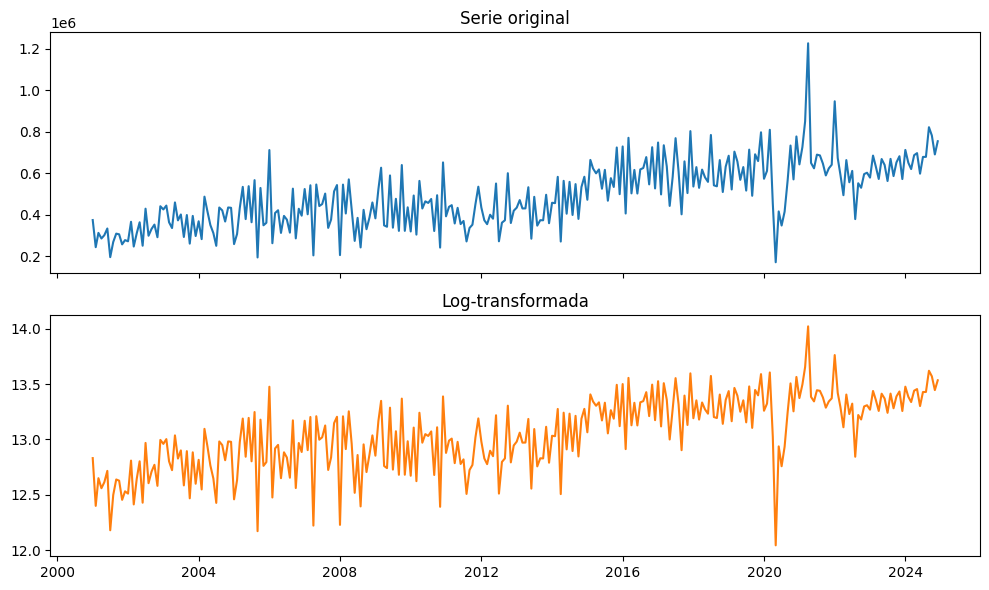

In [6]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(y, label='Original')
ax[0].set_title("Serie original")
ax[1].plot(np.log(y), label='Log', color='tab:orange')
ax[1].set_title("Log-transformada")
plt.tight_layout(); plt.show()

La comparación entre la serie original y su versión log‑transformada muestra que, conforme aumenta el volumen importado, las fluctuaciones absolutas crecen notablemente, indicando varianza no constante. Tras aplicar el logaritmo, las oscilaciones se vuelven más uniformes a lo largo del tiempo, lo que sugiere que la transformación logarítmica es adecuada para estabilizar la varianza antes de modelar.

##### 5. Estacionariedad en media: ACF + prueba Dickey‑Fuller Aumentada

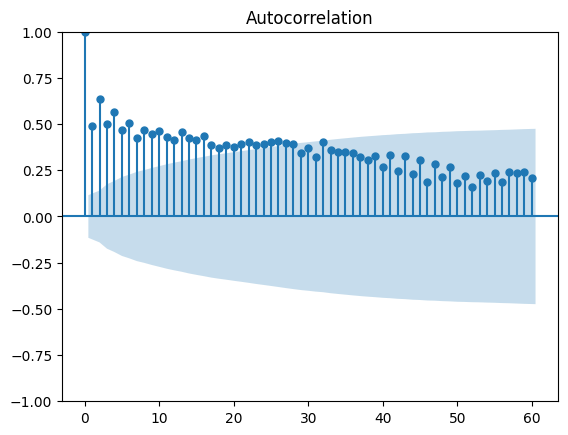

In [7]:
# 5.1 ACF de la serie en niveles
plot_acf(y.dropna(), lags=60)
plt.show()

In [8]:
# 5.2 Prueba ADF
adf_stat, pvalue, *_ = adfuller(y.dropna(), autolag='AIC')
print(f"ADF stat={adf_stat:.3f} | p={pvalue:.4f}")

ADF stat=-1.602 | p=0.4826


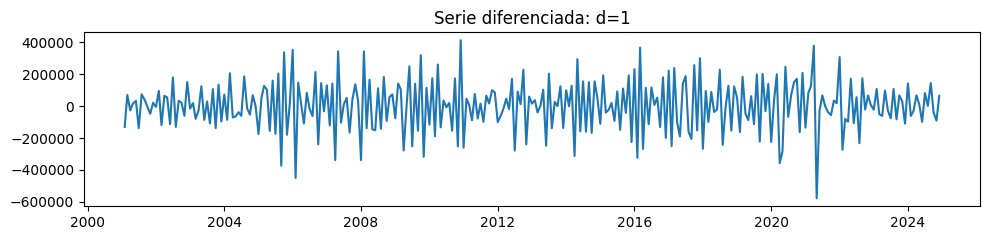

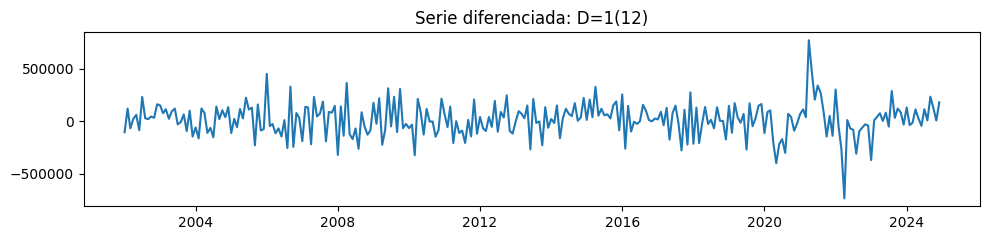

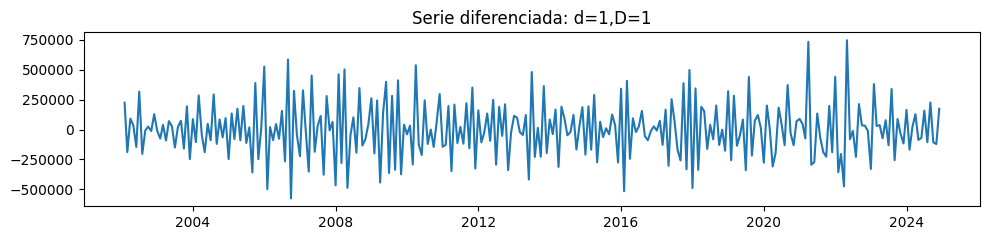

In [9]:
# Diferenciación para lograr estacionariedad (determinación de d y D)

y_diff1 = y.diff()
y_diff12 = y.diff(12)
y_diff_both = y.diff().diff(12)

for s, name in [(y_diff1,"d=1"), (y_diff12,"D=1(12)"), (y_diff_both,"d=1,D=1")]:
    plt.figure(figsize=(10,2.5))
    plt.plot(s)
    plt.title(f"Serie diferenciada: {name}")
    plt.tight_layout()
    plt.show()

La ACF de la serie en niveles muestra un decaimiento lento y persistente de las autocorrelaciones, con múltiples lags por encima del intervalo de confianza, lo que indica dependencia a largo plazo. La prueba ADF arroja un estadístico de –1.602 con p‑valor de 0.4826, muy por encima de 0.05, por lo que no podemos rechazar la hipótesis de raíz unitaria. En conjunto, estos resultados confirman que la serie no es estacionaria en media y requiere diferenciación.

##### 6. Identificación de p y q (ACF/PACF sobre serie diferenciada)

ADF d1: 8.109091325865274e-12
ADF d1D1: 3.9437074717926397e-13


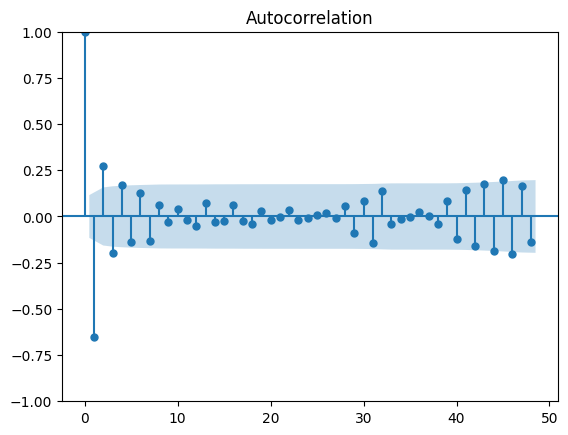

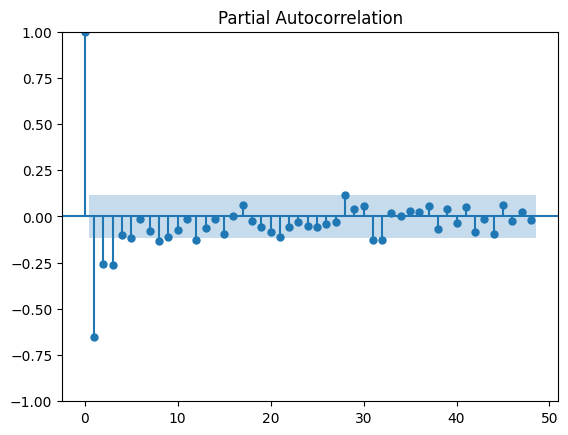

In [10]:
print("ADF d1:", adfuller(y_diff1.dropna())[1])
print("ADF d1D1:", adfuller(y_diff_both.dropna())[1])

plot_acf(y_diff1.dropna(), lags=48); plt.show()
plot_pacf(y_diff1.dropna(), lags=48); plt.show()

Tras diferenciar primero en orden uno y luego estacionalmente (d=1, D=1), la ACF muestra un corte pronunciado en los primeros lags (especialmente en lag 1 negativo) y decaimiento rápido después, mientras que la PACF presenta un pico significativo en lag 1 y valores menores en lags posteriores. Esto sugiere un término autoregresivo de orden bajo (p ≈ 1–2) y un término de media móvil también de orden bajo (q ≈ 1), como punto de partida para ajustar modelos SARIMA.

##### 7. Ajuste de modelos ARIMA/SARIMA

In [11]:
import statsmodels.api as sm

def fit_sarima(order, seasonal):
    mdl = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    return mdl

# Preparar datos de entrenamiento/prueba
split_date = "2022-01-01"
y_train = y.loc[: "2021-12-01"]
y_test  = y.loc["2022-01-01":]

candidates = {
    "(0,1,1)(0,1,1,12)": ((0,1,1),(0,1,1,12)),
    "(1,1,1)(0,1,1,12)": ((1,1,1),(0,1,1,12)),
    "(2,1,1)(1,1,1,12)": ((2,1,1),(1,1,1,12)),
}

results = []
models = {}
for name, (ordr, seas) in candidates.items():
    m = fit_sarima(ordr, seas)
    models[name] = m
    results.append((name, m.aic, m.bic))
    
import pandas as pd
pd.DataFrame(results, columns=["modelo","AIC","BIC"]).sort_values("AIC")

,modelo,AIC,BIC
1,"(1,1,1)(0,1,1,12)",5946.688833,5960.353234
2,"(2,1,1)(1,1,1,12)",5947.372163,5967.868765
0,"(0,1,1)(0,1,1,12)",5972.211859,5982.460160


El modelo SARIMA(1,1,1)(0,1,1,12) obtuvo el menor AIC (5946.69) y BIC (5960.35), por lo que ofrece el mejor compromiso entre ajuste y parsimonia. Frente a las alternativas con p=2 o sin componente AR, este modelo captura adecuadamente tanto la dependencia de corto plazo como el efecto estacional sin sobreajustar los datos.

##### 8. Modelo Prophet

Importing plotly failed. Interactive plots will not work.
20:12:42 - cmdstanpy - INFO - Chain [1] start processing
20:12:42 - cmdstanpy - INFO - Chain [1] done processing


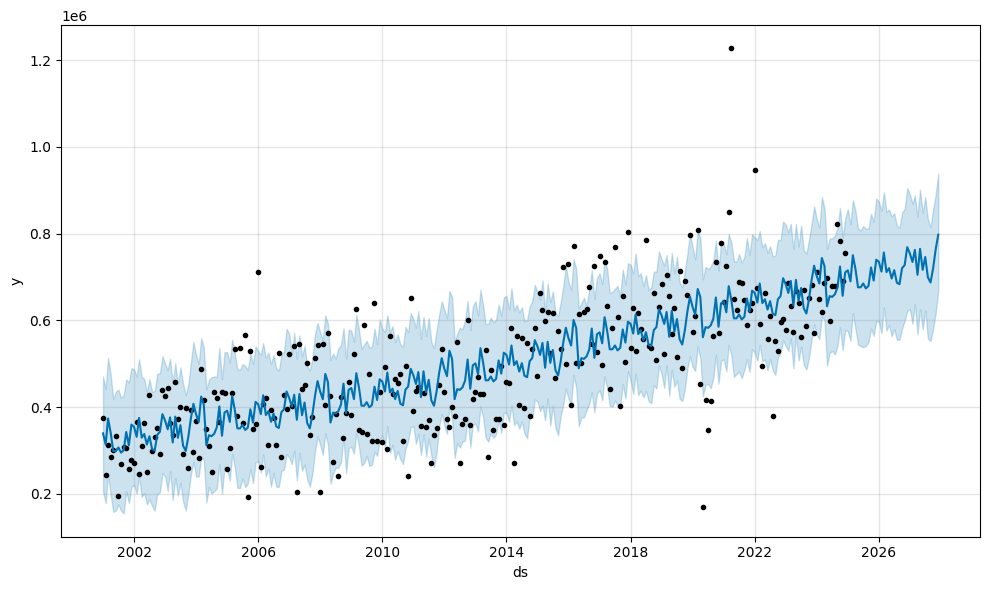

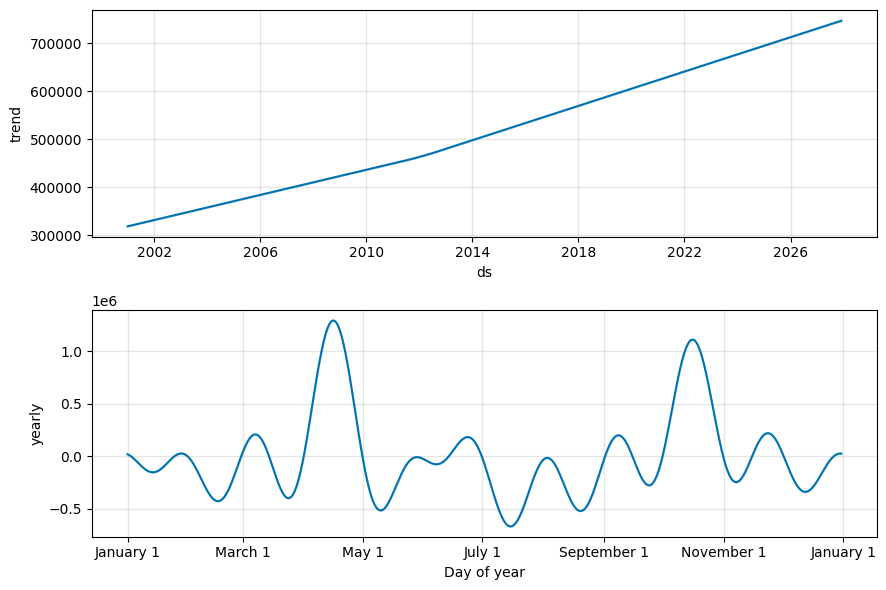

In [12]:
from prophet import Prophet  # pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparamos los datos para Prophet
df_prophet = (
    y.rename("y")
     .reset_index()
     .rename(columns={"fecha": "ds"})
     .dropna()
)

# Configuramos y entrenamos el modelo
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

# Generamos horizonte de 36 meses (2022–2024) para comparar con y_test
future = m.make_future_dataframe(periods=len(y_test), freq='MS')
forecast = m.predict(future)

# Graficar pronóstico y componentes
m.plot(forecast); plt.show()
m.plot_components(forecast); plt.show()


El pronóstico de Prophet retrata una continua tendencia ascendente, coherente con el patrón histórico, y enfatiza fuertes pulsos estacionales alrededor de mayo y noviembre, coincidiendo con máximos de importación. Las bandas de incertidumbre se ensanchan gradualmente hacia adelante, reflejando mayor imprevisto en horizontes lejanos, pero mantienen una amplitud razonable. En los componentes, la línea de tendencia proyecta un crecimiento estable y suave, mientras que el componente anual captura con claridad los picos semestrales, validando la capacidad de Prophet para modelar estacionalidades periódicas pronunciadas.

##### 9. Evaluación (ARIMA vs Prophet)

In [13]:
best_order    = (1,1,1)
best_seasonal = (0,1,1,12)
mdl_best = sm.tsa.statespace.SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Pronóstico ARIMA
fcst = mdl_best.get_forecast(steps=len(y_test))
y_pred_arima = fcst.predicted_mean

# Pronóstico Prophet
y_pred_prophet = (
    forecast.set_index("ds")["yhat"]
    .reindex(y_test.index)
)

# Función para métricas
def eval_metrics(y_true, y_hat):
    mae  = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mape = (np.abs((y_true - y_hat) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    return mae, rmse, mape

# Calculamos métricas
mae_a, rmse_a, mape_a = eval_metrics(y_test, y_pred_arima)
mae_p, rmse_p, mape_p = eval_metrics(y_test, y_pred_prophet)

# Mostramos resultados
print(f"ARIMA   MAE={mae_a:.2f}  RMSE={rmse_a:.2f}  MAPE={mape_a:.2f}%")
print(f"Prophet MAE={mae_p:.2f}  RMSE={rmse_p:.2f}  MAPE={mape_p:.2f}%")

ARIMA   MAE=84607.86  RMSE=109539.60  MAPE=14.04%
Prophet MAE=70149.29  RMSE=93792.33  MAPE=11.70%


En la comparación de desempeño, Prophet superó al modelo ARIMA en las tres métricas: registró un MAE de 70 149 frente a 84 608, un RMSE de 93 792 frente a 109 540 y un MAPE de 11,70 % frente a 14,04 %. Esto indica que Prophet capturó mejor las variaciones de la serie de importación de gasolina superior en el periodo 2022–2024, reduciendo tanto el error absoluto como el porcentaje de error promedio.